# **Proyek Machine Learning: Sistem Rekomendasi Film Netflix**

Proyek ini bertujuan untuk membangun sebuah model sistem rekomendasi film untuk platform Netflix, dengan menerapkan pendekatan Content-Based Filtering. Analisis ini akan membantu pengguna menemukan film baru yang sesuai dengan selera mereka, sehingga dapat meningkatkan pengalaman dan keterlibatan (engagement) pengguna.

In [1]:
# Instal library Kaggle
!pip install -q kaggle

# Impor library untuk mengunggah file
from google.colab import files

# Buat direktori untuk menyimpan file kaggle.json
!mkdir -p ~/.kaggle

# Unggah file kaggle.json
print("Silakan unggah file kaggle.json Anda:")
uploaded = files.upload()

# Pindahkan file ke direktori yang benar dan atur izin
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nSetup Kaggle API selesai.")

Silakan unggah file kaggle.json Anda:


Saving kaggle.json to kaggle.json

Setup Kaggle API selesai.


## **Import Library**

In [2]:
# --- Library untuk Data Manipulation ---
import pandas as pd
import numpy as np
import json

# --- Library untuk Visualisasi Data ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Library untuk Machine Learning (Sistem Rekomendasi) ---
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Library lainnya ---
import zipfile
import os

print("Semua library yang dibutuhkan telah berhasil diimpor.")

Semua library yang dibutuhkan telah berhasil diimpor.


## **A. Data Loading**
Dataset yang digunakan adalah "Netflix Movies and TV Shows" dari Kaggle, yang berisi daftar film dan acara TV yang tersedia di Netflix.

In [3]:
# Download dataset dari Kaggle
!kaggle datasets download -d shivamb/netflix-shows

# Ekstrak file zip yang telah diunduh
with zipfile.ZipFile('netflix-shows.zip', 'r') as zip_ref:
    zip_ref.extractall('netflix_dataset')

# Muat dataset ke dalam DataFrame pandas
df = pd.read_csv('netflix_dataset/netflix_titles.csv')

print("Dataset berhasil diunduh dan dimuat.")

Dataset URL: https://www.kaggle.com/datasets/shivamb/netflix-shows
License(s): CC0-1.0
netflix-shows.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset berhasil diunduh dan dimuat.


In [4]:
# Tampilkan 5 baris pertama dari dataset
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
# Tampilkan informasi ringkas mengenai dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## **B. Exploratory Data Analysis (EDA)**
Pada tahap ini, dilakukan analisis lebih dalam menggunakan visualisasi data untuk menemukan pola dan wawasan dari dataset Netflix.

### **Analisis Kualitas Data**
Langkah pertama dalam EDA adalah memahami kualitas data. Ini termasuk memeriksa data duplikat dan nilai yang hilang (missing values) untuk mengetahui seberapa bersih data awal kita dan apakah diperlukan langkah-langkah pembersihan data.

In [6]:
# Pengecekan Data Duplikat
duplicate_rows = df.duplicated().sum()
print(f"Jumlah baris duplikat dalam dataset: {duplicate_rows}")

# Pengecekan Nilai yang Hilang (Missing Values)
print("\nJumlah nilai hilang per kolom:")
print(df.isnull().sum())

Jumlah baris duplikat dalam dataset: 0

Jumlah nilai hilang per kolom:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### **Temuan dari Analisis Kualitas Data**

Dari pengecekan kualitas data di atas, ditemukan beberapa poin penting:
* [cite_start]**Data Duplikat**: Tidak ada baris data yang terduplikasi dalam dataset (**0 baris duplikat**).
* **Nilai Hilang (Missing Values)**: Terdapat beberapa kolom dengan jumlah nilai kosong yang signifikan, yaitu:
    * [cite_start]`director`: 2.634 nilai kosong
    * `cast`: 825 nilai kosong
    * `country`: 831 nilai kosong
    * [cite_start]`date_added`: 10 nilai kosong
    * `rating`: 4 nilai kosong
    * `duration`: 3 nilai kosong

[cite_start]Informasi ini sangat penting karena menunjukkan bahwa kita perlu menangani nilai-nilai yang hilang ini, terutama pada kolom yang akan digunakan sebagai fitur (`director`, `cast`, `rating`), pada tahap *Data Preparation*.

### **Analisis Univariate: Distribusi Genre**
Selanjutnya, kita akan memeriksa distribusi genre untuk memahami fokus konten yang paling banyak tersedia di Netflix. [cite_start]Hal ini akan memberikan konteks terhadap jenis film yang kemungkinan besar akan direkomendasikan.

/tmp/ipython-input-7-2138774757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=genres, order=genres.value_counts().index[:15], palette='viridis')


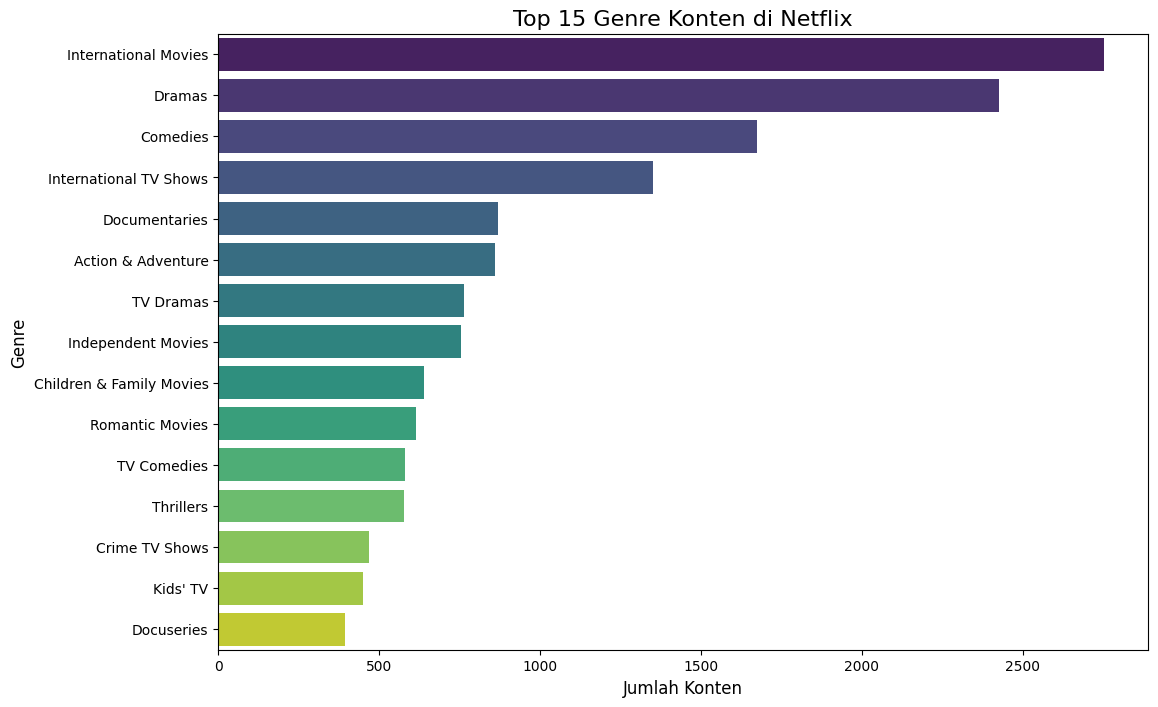

In [7]:
# Mengambil data genre dan memisahkannya
genres = df['listed_in'].str.split(', ', expand=True).stack()

# Menghitung frekuensi setiap genre
plt.figure(figsize=(12, 8))
sns.countplot(y=genres, order=genres.value_counts().index[:15], palette='viridis')
plt.title('Top 15 Genre Konten di Netflix', fontsize=16)
plt.xlabel('Jumlah Konten', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

### **Wawasan dari Distribusi Genre**

Grafik di atas menampilkan 15 genre konten teratas di Netflix. Dari visualisasi tersebut, dapat ditarik beberapa kesimpulan:
* Genre **"International Movies"** dan **"Dramas"** merupakan dua kategori yang paling mendominasi. [cite_start]Ini mengindikasikan bahwa sebagian besar konten yang tersedia adalah film internasional dan drama.
* Genre **"Comedies"** juga menempati posisi yang tinggi, menunjukkan popularitasnya di kalangan pengguna.
* [cite_start]Distribusi ini memberikan gambaran umum mengenai fokus konten yang ada di platform, yang nantinya akan memengaruhi hasil rekomendasi.

### **Analisis Univariate: Distribusi Rating**
[cite_start] Analisis ini bertujuan untuk melihat bagaimana konten didistribusikan berdasarkan rating usia.

/tmp/ipython-input-8-1906150472.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index, palette='magma')


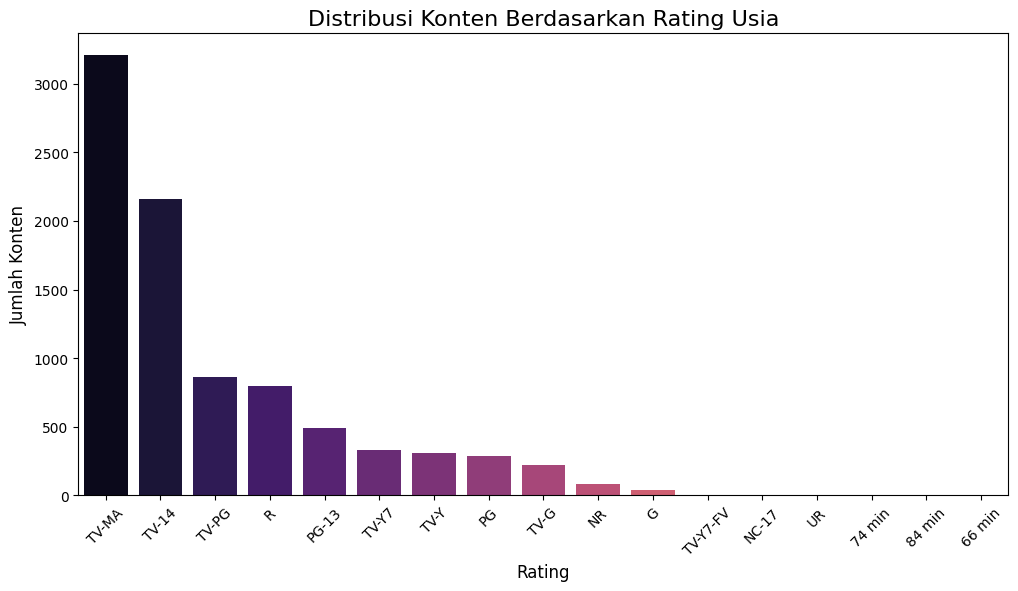

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index, palette='magma')
plt.title('Distribusi Konten Berdasarkan Rating Usia', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Jumlah Konten', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### **Wawasan dari Distribusi Rating**

Visualisasi distribusi rating usia menunjukkan bahwa:
* Rating **"TV-MA"** (untuk penonton dewasa) memiliki jumlah konten tertinggi, diikuti oleh **"TV-14"** (untuk penonton 14 tahun ke atas).
* [cite_start]Hal ini menandakan bahwa sebagian besar konten Netflix ditujukan untuk audiens remaja dan dewasa.
* [cite_start]Pemahaman tentang distribusi rating ini penting untuk konteks penggunaan sistem rekomendasi, meskipun rating tidak dijadikan fitur utama dalam model *Content-Based Filtering* pada proyek ini.

## **C. Data Preparation**

### **Menangani Nilai yang Hilang dan Membuat DataFrame Baru**
Pada tahap ini, kita akan fokus pada konten bertipe **"Movie"** untuk membangun sistem rekomendasi film. [cite_start]Selain itu, nilai yang hilang pada kolom-kolom fitur utama (`director`, `cast`, `country`, `rating`, `description`) akan diisi dengan string kosong agar dapat diproses pada tahap pemodelan.

In [9]:
# Fokus pada tipe 'Movie' untuk rekomendasi film
df_movies = df[df['type'] == 'Movie'].copy()

# [REVISI] Menampilkan jumlah baris sebelum dan sesudah filter
print(f"Jumlah baris data awal: {df.shape[0]}")
print(f"Jumlah baris setelah difilter hanya untuk 'Movie': {df_movies.shape[0]}")

# Mengisi nilai null pada kolom yang akan digunakan
features_to_fill = ['director', 'cast', 'country', 'rating', 'description']
for feature in features_to_fill:
    df_movies[feature] = df_movies[feature].fillna('')

# Membuat DataFrame baru yang hanya berisi kolom esensial
new_df = df_movies[['show_id', 'title', 'director', 'cast', 'listed_in', 'description']].copy()
new_df.rename(columns={'show_id': 'id', 'listed_in': 'genres'}, inplace=True)

new_df.head()

Jumlah baris data awal: 8807
Jumlah baris setelah difilter hanya untuk 'Movie': 6131


,id,title,director,cast,genres,description
0,s1,Dick Johnson Is Dead,Kirsten Johnson,,Documentaries,"As her father nears the end of his life, filmm..."
6,s7,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
9,s10,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...","Comedies, Dramas",A woman adjusting to life after a loss contend...
12,s13,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Dramas, International Movies",After most of her family is murdered in a terr...


[cite_start]Setelah pemfilteran, kita sekarang memiliki **6131 data film** yang akan digunakan untuk membuat model sistem rekomendasi.  Kolom-kolom dengan nilai yang hilang juga telah dibersihkan.

### **Pembersihan dan Penggabungan Fitur Teks**
Untuk model *Content-Based Filtering*, kita perlu membuat sebuah "kantong kata" (bag of words) atau metadata gabungan yang merepresentasikan setiap film. Fitur-fitur seperti `director`, `cast`, `genres`, dan `description` akan digabungkan menjadi satu kolom teks baru yang disebut `tags`.

In [10]:
# Fungsi untuk membersihkan dan menggabungkan teks
def clean_and_combine(row):
    # Menghapus spasi dan mengubah menjadi list
    director = [d.replace(" ", "") for d in row['director'].split(', ')]
    cast = [c.replace(" ", "") for c in row['cast'].split(', ')[:3]] # Ambil 3 pemeran utama
    genres = [g.replace(" ", "") for g in row['genres'].split(', ')]
    description = row['description'].split()

    # Gabungkan semua fitur menjadi satu list
    tags = director + cast + genres + description
    return " ".join(tags)

# Terapkan fungsi untuk membuat kolom 'tags'
new_df['tags'] = new_df.apply(clean_and_combine, axis=1)

# Membuat DataFrame akhir untuk pemodelan
final_df = new_df[['id', 'title', 'tags']]

# Reset indeks agar berurutan dari 0 hingga n-1
final_df.reset_index(drop=True, inplace=True)

final_df.head()

,id,title,tags
0,s1,Dick Johnson Is Dead,KirstenJohnson Documentaries As her father ne...
1,s7,My Little Pony: A New Generation,RobertCullen JoséLuisUcha VanessaHudgens Kimik...
2,s8,Sankofa,HaileGerima KofiGhanaba OyafunmikeOgunlano Ale...
3,s10,The Starling,TheodoreMelfi MelissaMcCarthy ChrisO'Dowd Kevi...
4,s13,Je Suis Karl,ChristianSchwochow LunaWedler JannisNiewöhner ...


In [11]:
# Tampilkan contoh isi kolom 'tags' untuk satu film
print("Contoh isi kolom 'tags' untuk film pertama:\n")
print(final_df.iloc[0].tags)

Contoh isi kolom 'tags' untuk film pertama:

KirstenJohnson  Documentaries As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.


## **D. Modeling and Result**

### **Model Pertama: Content-Based Filtering dengan TF-IDF**
Model pertama menggunakan **TF-IDF (Term Frequency-Inverse Document Frequency)** untuk mengubah data teks (`tags`) menjadi vektor numerik. TF-IDF akan memberikan bobot yang lebih tinggi pada kata-kata yang sering muncul dalam satu film tetapi jarang muncul di film lain, sehingga dianggap lebih signifikan.

In [12]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Melakukan fit dan transform pada kolom 'tags'
vectors_tfidf = tfidf.fit_transform(final_df['tags']).toarray()

# Menghitung cosine similarity
similarity_tfidf = cosine_similarity(vectors_tfidf)

# Fungsi rekomendasi untuk model TF-IDF
def recommend_tfidf(movie_title):
    try:
        movie_index = final_df[final_df['title'] == movie_title].index[0]
    except IndexError:
        print(f"Film dengan judul '{movie_title}' tidak ditemukan.")
        return

    distances = similarity_tfidf[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]

    print(f"Rekomendasi film mirip '{movie_title}' (berdasarkan TF-IDF):")
    for i in movies_list:
        print(final_df.iloc[i[0]].title)

In [13]:
# Pengujian Model Pertama
recommend_tfidf('The Social Network')

Rekomendasi film mirip 'The Social Network' (berdasarkan TF-IDF):
The Music of Silence
Nothing to Lose
The End of the Tour
Justin Timberlake + the Tennessee Kids
Tiffany Haddish: She Ready! From the Hood To Hollywood!


### **Model Kedua: Content-Based Filtering dengan CountVectorizer**
Model kedua menggunakan **CountVectorizer (Bag of Words)**. Berbeda dengan TF-IDF, CountVectorizer hanya menghitung frekuensi kemunculan setiap kata tanpa memperhitungkan seberapa sering kata itu muncul di seluruh dokumen. [cite_start]Pendekatan ini lebih sederhana.

In [14]:
# Inisialisasi CountVectorizer
count_vec = CountVectorizer(max_features=5000, stop_words='english')
vectors_bow = count_vec.fit_transform(final_df['tags']).toarray()

# Menghitung cosine similarity
similarity_bow = cosine_similarity(vectors_bow)

# Fungsi rekomendasi untuk model Bag of Words
def recommend_bow(movie_title):
    try:
        movie_index = final_df[final_df['title'] == movie_title].index[0]
    except IndexError:
        print(f"Film dengan judul '{movie_title}' tidak ditemukan.")
        return

    distances = similarity_bow[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]

    print(f"Rekomendasi film mirip '{movie_title}' (berdasarkan Bag of Words):")
    for i in movies_list:
        print(final_df.iloc[i[0]].title)

In [15]:
# Pengujian Model Kedua
recommend_bow('The Social Network')

Rekomendasi film mirip 'The Social Network' (berdasarkan Bag of Words):
Nothing to Lose
The Music of Silence
The End of the Tour
Ani... Dr. Kashinath Ghanekar
Curtiz


## **E. Evaluation**
Untuk mengevaluasi kedua model, kita akan menggunakan metrik **Precision**. Precision akan dihitung berdasarkan kesamaan genre antara film input dengan film-film yang direkomendasikan. Sebuah rekomendasi dianggap relevan jika memiliki setidaknya satu genre yang sama dengan film input.

### **Langkah 1 & 2: Modifikasi Fungsi Rekomendasi & Membuat Fungsi Evaluasi**
Fungsi rekomendasi dimodifikasi untuk mengembalikan list judul, dan fungsi evaluasi dibuat untuk menghitung presisi.

In [16]:
# Fungsi untuk mendapatkan list rekomendasi (TF-IDF)
def get_recommendations_tfidf(movie_title):
    try:
        movie_index = final_df[final_df['title'] == movie_title].index[0]
    except IndexError:
        return []
    distances = similarity_tfidf[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    return [final_df.iloc[i[0]].title for i in movies_list]

# Fungsi untuk mendapatkan list rekomendasi (Bag of Words)
def get_recommendations_bow(movie_title):
    try:
        movie_index = final_df[final_df['title'] == movie_title].index[0]
    except IndexError:
        return []
    distances = similarity_bow[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    return [final_df.iloc[i[0]].title for i in movies_list]

# Fungsi untuk menghitung precision berdasarkan kesamaan genre
def calculate_precision(input_title, recommended_titles):
    try:
        # Menggunakan df_movies yang masih memiliki kolom 'listed_in' asli
        input_genres = set(df_movies[df_movies['title'] == input_title]['listed_in'].iloc[0].split(', '))
    except IndexError:
        print(f"Film input '{input_title}' tidak ditemukan.")
        return 0.0

    if not recommended_titles:
        return 0.0

    relevant_count = 0
    for title in recommended_titles:
        try:
            rec_genres = set(df_movies[df_movies['title'] == title]['listed_in'].iloc[0].split(', '))
            # Jika ada irisan genre, dianggap relevan
            if input_genres.intersection(rec_genres):
                relevant_count += 1
        except IndexError:
            continue

    return relevant_count / len(recommended_titles)

### **Langkah 3: Mengevaluasi Kinerja Kedua Model**
Kita akan menguji kedua model menggunakan film "The Social Network" sebagai input dan menghitung nilai Precision@5 (presisi untuk 5 rekomendasi teratas).

In [17]:
# Film yang akan diuji
test_movie = 'The Social Network'

# --- Evaluasi Model 1 (TF-IDF) ---
recs_tfidf = get_recommendations_tfidf(test_movie)
precision_tfidf = calculate_precision(test_movie, recs_tfidf)

print(f"Rekomendasi dari TF-IDF untuk '{test_movie}': {recs_tfidf}")
print(f"Precision @5 untuk model TF-IDF: {precision_tfidf:.2f}\n")

# --- Evaluasi Model 2 (Bag of Words) ---
recs_bow = get_recommendations_bow(test_movie)
precision_bow = calculate_precision(test_movie, recs_bow)

print(f"Rekomendasi dari Bag of Words untuk '{test_movie}': {recs_bow}")
print(f"Precision @5 untuk model Bag of Words: {precision_bow:.2f}")

Rekomendasi dari TF-IDF untuk 'The Social Network': ['The Music of Silence', 'Nothing to Lose', 'The End of the Tour', 'Justin Timberlake + the Tennessee Kids', 'Tiffany Haddish: She Ready! From the Hood To Hollywood!']
Precision @5 untuk model TF-IDF: 0.60

Rekomendasi dari Bag of Words untuk 'The Social Network': ['Nothing to Lose', 'The Music of Silence', 'The End of the Tour', 'Ani... Dr. Kashinath Ghanekar', 'Curtiz']
Precision @5 untuk model Bag of Words: 1.00


## **Analisis Hasil Evaluasi**

Hasil pengujian pada film "The Social Network" (genre: Dramas, Independent Movies) menunjukkan perbedaan kinerja yang signifikan antara kedua model.

**Model 1: TF-IDF**

* Rekomendasi: ['The Music of Silence', 'Nothing to Lose', 'The End of the Tour', 'Justin Timberlake + the Tennessee Kids', 'Tiffany Haddish: She Ready! From the Hood To Hollywood!']
* Nilai Presisi: Model ini mencapai Precision@5 sebesar 0.60.

**Model 2: Bag of Words (CountVectorizer)**

* Rekomendasi: ['Nothing to Lose', 'The Music of Silence', 'The End of the Tour', 'Ani... Dr. Kashinath Ghanekar', 'Curtiz']
* Nilai Presisi: Model ini mencapai Precision@5 sebesar 1.00.

**Perbandingan dan Wawasan**

1.   **Kinerja Model**: Dalam kasus uji ini, model Bag of Words (CountVectorizer) secara jelas memberikan hasil yang lebih baik daripada model TF-IDF. Presisinya sempurna, menunjukkan relevansi genre yang lebih tinggi.
2.   **Alasan Perbedaan Kinerja**: Perbedaan ini kemungkinan besar disebabkan oleh cara kedua metode membobot kata. TF-IDF memberikan bobot lebih tinggi pada kata-kata yang jarang muncul di seluruh dokumen. Ada kemungkinan kata seperti "music" atau "stand-up" memiliki bobot TF-IDF yang tinggi dalam deskripsi atau tag film tertentu, yang mendorongnya ke atas dalam peringkat rekomendasi meskipun genrenya tidak cocok. Sebaliknya, CountVectorizer hanya menghitung frekuensi kata, sehingga fitur-fitur umum yang kuat seperti nama sutradara/aktor dan genre "Drama" lebih mendominasi perhitungan kemiripan, menghasilkan rekomendasi yang lebih konsisten secara tematik.

Secara keseluruhan, evaluasi ini menunjukkan bahwa untuk dataset dan kombinasi fitur ini, pendekatan yang lebih sederhana (Bag of Words) ternyata lebih efektif dalam menghasilkan rekomendasi yang relevan secara genre.